In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import timezone, timedelta

data = pd.read_csv('user_post.csv', encoding= 'latin')
data = data[data['post_time'].notna()]
data.sample(5)

,post_id,post_time,content,poster_id,poster_url,repost_num,comment_num,repost_post_id,inner_flag
42203,3.720760e+15,2014/6/12 21:49,ËÄÄêÒ»´ÎµÄÊÀ½ç±­Ê¢ÑçÖÕÓÚÒª¿ªÊ¼ÁË£¬ÄÄÁ½Ö§Çò¶ÓÄÜ...,1.092538e+09,http://weibo.com/1092538373,583.0,164.0,NaN,NaN
19733,3.678330e+15,2014/2/15 20:15,Ð¡¿É°®¼ÓÓÍ£¡@¸ßÔÃ-,1.822575e+09,http://weibo.com/1822574697,0.0,0.0,NaN,NaN
5039,3.735100e+15,2014/7/22 11:26,×ª·¢Î¢²©,1.195265e+09,http://weibo.com/1195264701,0.0,0.0,NaN,
10533,3.776950e+15,2014/11/14 23:30,×ª·¢Î¢²©,3.089819e+09,http://weibo.com/3089819133,0.0,1.0,NaN,
2758,3.767570e+15,2014/10/20 2:26,×ª·¢Î¢²©,2.623806e+09,http://weibo.com/2623806357,0.0,0.0,NaN,


In [2]:
data_corrected = data.copy()
data_corrected['dated'] = pd.to_datetime(data_corrected['post_time'])

# We create two new columns containing the day and the hour at which the tweet was posted.
data_corrected['Weekday']  = data_corrected['dated'].apply(lambda x: x.weekday())
data_corrected['Hour'] = data_corrected['dated'].apply(lambda x: x.strftime('%H'))

In [3]:
# We can directly group the number of tweet by day and by hour interval.
daily_post = data_corrected.groupby(["Weekday","Hour"]).size()

# We first group the number of tweets by user, by day and by hour. 
# Then we can get the number of user there is for each day and hour interval. 
daily_users = data_corrected.groupby(["Weekday","Hour","poster_id"]).sum()
daily_users = daily_users.groupby(["Weekday","Hour"]).size()

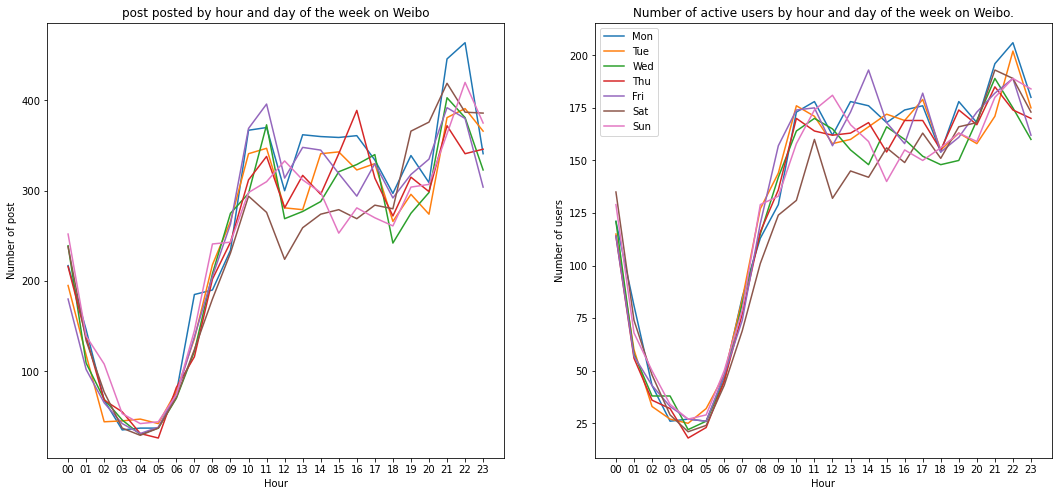

In [4]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
days = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
for day in range(7):
    ax[0].plot(daily_post[day])
    ax[1].plot(daily_users[day],label=days[day])
    
ax[0].set_xlabel('Hour')
ax[0].set_ylabel('Number of post')
ax[0].set_title("post posted by hour and day of the week on Weibo")

ax[1].legend()
ax[1].set_xlabel('Hour')
ax[1].set_ylabel('Number of users')
ax[1] = ax[1].set_title("Number of active users by hour and day of the week on Weibo.")

In [5]:
Egos = data_corrected.groupby(["poster_id"]).size()

In [6]:
def get_ccdf(vals):
    # Input:
    # -- vals: an np.array of integers greater or equal to 0 ( this method doesn't include the value for the number of tweet = 0, 
    # we could eventually manually add it, but wee will understand better the problem in the analysis of the results just below and how this is corrected)
    # Output:
    # -- x: an array containing all numbers from 1 to max(vals) + 2;
    # -- y: an array containing the (empirically calculated) probability that vals >= x
    
    # bincount count number of occurrences for each value in the array so we must give all the range of vals
    y = np.cumsum(np.bincount(vals)) 
    y = y/y[-1]
    
    # Take the complementary probability, so it give us the probability that vals >= x
    y = 1-y 
    
    x = list(range(1, max(vals) + 2))
    
    return x, y

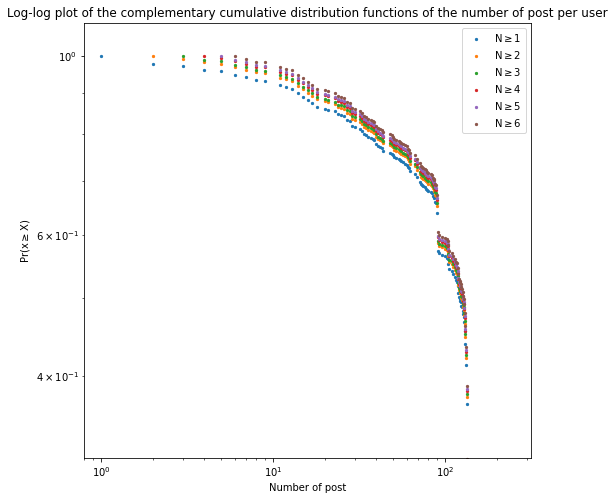

In [7]:
f, ax = plt.subplots(figsize=(8, 8))
first_values = []
for i in range(6):
    # We calculate the CCDF for the different N
    x, y = get_ccdf(Egos[Egos>i].astype(int)) 
    # We convert the data as a Dataframe to ease the manipulations.
    Ego_ccdf = pd.DataFrame({'ccdf': y}, index = x) 
    # We remove all the identical values exept the last one in order to not have horizontal line in the scatter plot.
    Ego_ccdf = Ego_ccdf.drop_duplicates(subset = "ccdf", keep="last")
    ax.scatter(Ego_ccdf.index, Ego_ccdf.ccdf, s = 5, label="N$\geq${}".format(i+1))
    # We store the first values of each ccdf (for the analysis of the results)
    first_values.append(Ego_ccdf[0:2].values) 

ax.legend()
ax.set_xlim((0.8,10**2.5))
ax.set_ylim((10**-0.5,1.1))
ax.set(xscale="log", yscale="log")
ax.set_xlabel('Number of post')
ax.set_ylabel('Pr(x$\geq$X)')
ax = ax.set_title("Log-log plot of the complementary cumulative distribution functions of the number of post per user")

# Power law with second dataset

In [8]:
data_2 = pd.read_csv('week1.csv', encoding= 'latin', dtype={'permission_denied': str})
data_2.sample(5)

,mid,retweeted_status_mid,uid,retweeted_uid,source,image,text,geo,created_at,deleted_last_seen,permission_denied
91629,mAaBrd5nX3,NaN,u0ABXZYX3,NaN,2012çiPhoneå®¢æ·ç«¯,1,å¸å¦ååå¸å¦å[åå][åå],NaN,2012-01-02 15:39:16,NaN,NaN
2005114,mc93APy3ER,mSFZgTW4KP,uAHFO1H3A,NaN,2012çiPhoneå®¢æ·ç«¯,0,[å¨æ­¦],NaN,2012-01-05 09:47:15,NaN,NaN
4390098,mjBPoAvCi0,mc93n2zMdc,u5KYESXKX,NaN,æ°æµªå¾®åä¸ä¸ç,0,//@uknï¼ //@uRSRD0G5Dï¼ ç»è³æµä¸åºçµå...,NaN,2012-01-08 13:46:23,NaN,NaN
1960274,mtqoFad4F8,muy8SWsBbk,uS5WZGI5H,NaN,å¾®åæ¡é¢,0,è½¬åå¾®å,NaN,2012-01-04 23:07:06,NaN,NaN
350923,m9hqkQVwQi,NaN,uQHCEYGUM,NaN,iPhoneå®¢æ·ç«¯,1,ä¸¤åªé¿ææ¯å åæççèµ·æ¥æ¯å¨éªä...,NaN,2012-01-02 10:45:07,NaN,NaN


In [9]:
Egos_part = data_2.groupby(["uid"]).size()

In [10]:
data_users = pd.read_csv('userdata.csv')
data_users.sample(5)

,uid,province,gender,verified
10270654,uCBTCY5PM,11,f,False
5720640,uPVDDOS5J,61,f,False
8174569,uB4HN0KAQ,44,f,False
1385620,uQZ0QHSXW,37,f,False
7079943,uVEQVZTTD,33,f,False


In [11]:
data_users = data_users.groupby(["uid"]).size()
Egos = pd.concat([Egos_part, data_users], axis=1, sort=False).iloc[:, 0].fillna(0)

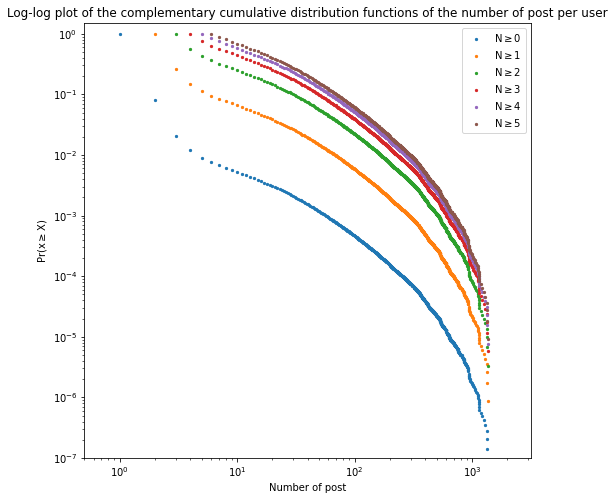

In [12]:
f, ax = plt.subplots(figsize=(8, 8))

first_values = []
for i in range(6):
    # We calculate the CCDF for the different N with a shift of +1 !
    x, y = get_ccdf(Egos[Egos>=i].astype(int) + 1 )
    Ego_ccdf = pd.DataFrame({'ccdf': y}, index = x) 
    Ego_ccdf = Ego_ccdf.drop_duplicates(subset = "ccdf", keep="last")
    ax.scatter(Ego_ccdf.index, Ego_ccdf.ccdf, s = 5, label="N$\geq${}".format(i))
    first_values.append(Ego_ccdf[0:2].values)
    
ax.legend()
ax.set_xlim((0.5,10**3.5))
ax.set_ylim((10**-7,1.5))
ax.set(xscale="log", yscale="log")
ax.set_xlabel('Number of post')
ax.set_ylabel('Pr(x$\geq$X)')
ax = ax.set_title("Log-log plot of the complementary cumulative distribution functions of the number of post per user")